# Social Interaction in Autism-Related Rat Models: Behavioral Phenotyping of Arid1b, Grin2b, and Scn2a Strains

This tutorial shows how to access the data related to [EMBER:000203](https://dandi.emberarchive.org/dandiset/000203) using pynwb.

This dataset contains behavioral data from the one trial social experiment, part of the [Rat Behavioural Phenotyping Pipeline Methodologies](https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/).

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Access Devices Metadata](#devices)
4. [Access Behavioral Videos](#behavior)
5. [Access Annotated Behavioral Events](#events)
6. [Access USV Data](#usv)



---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [1]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient, DandiInstance

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [2]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    dandi_instance = DandiInstance(
        "ember",
        "https://dandi.emberarchive.org",
        "https://api-dandi.emberarchive.org/api",
    )
    with DandiAPIClient(dandi_instance=dandi_instance) as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )

        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)

        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")

        s3_url = s3_urls[0]

    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()

    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}.nwb"
    
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")
    
    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io

In [3]:
# Load session data
dandiset_id = "000203"
session_id = "1TS-Test"
subject_id = "635-Arid1b(11)"

# Choose data source (DANDI streaming or local)
USE_DANDI = True  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = "YOUR_DIRECTORY_PATH"  # Replace with actual path
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [4]:
print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/.
As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. 
Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. 
Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through.
This experiment investigated social interaction behavior in different rat models 
(Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, 
Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, 
Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530).
T

In [5]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Species: {nwbfile.subject.species}")
print(f"Strain: {nwbfile.subject.strain}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: 635_Arid1b(11)
Age: None
Species: Rattus norvegicus
Strain: Arid1b
Genotype: HET
Sex: F


---

# 3. Access Devices Metadata <a id="devices"></a>

This section demonstrates how to access the [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field in an NWB file.

The [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field can be accessed as `nwbfile.devices`.

In [6]:
nwbfile.devices["camera_device 0"]

camera_device 0 abc.CameraDevice at 0x3206382355536
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

In [7]:
nwbfile.devices["Arena"]

Arena pynwb.device.Device at 0x3206382355280
Fields:
  description: Custom built arena (60x60 cm) with white laminated wood walls and floor
  manufacturer: Kanya UK

In [8]:
nwbfile.devices["USVMicrophone"]

USVMicrophone pynwb.device.Device at 0x3206382578640
Fields:
  description: M500 USB Pettersson microphone for recording ultrasonic vocalizations, hanging approx. 1.5 m above the arena.
  manufacturer: Pettersson, Wildlife Services UK

---

# 4. Access Behavioral Video <a id="behavior"></a>

The behavioral video is stored as an external `ImageSeries` in the NWB file.

In [9]:
video = nwbfile.acquisition["BehavioralVideo"]
video

Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Uncompressed size (bytes),0
Compressed size (bytes),0
Compression ratio,undefined
Data type,float64
Shape,"(33427,)"


The video filepath:

In [10]:
video.external_file[0]

'sub-635-Arid1b(11)_ses-1TS-Test_image\\3fda6dc9-8bcc-4f81-ad6d-4a3cee83afc7_external_file_0.mp4'

The metadata of the device used to record the behavioral video:


In [11]:
video.device

camera_device 0 abc.CameraDevice at 0x3206382355536
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

---

# 5. Access Annotated Behavioral Events <a id="events"></a>

The `nwbfile.processing["events]` contains annotated events. These are stored in the `AnnotatedEventsTable` type. The `AnnotatedEventsTable` type is a subtype of `DynamicTable`, where each row corresponds to a different event type. The table has a ragged (variable-length) 1D column of event times, such that each event type (row) is associated with an array of event times

You can convert the table to a `pandas.DataFrame` for easier exploration:


In [12]:
behavioral_events = nwbfile.processing["behavior"]["AnnotatedBehavioralEvents"].to_dataframe()
behavioral_events

,duration,event_times,label,event_description
id,,,,
0,"[10.050000000000011, 5.315999999999974, 45.016...","[341.533, 356.117, 363.033, 414.317, 427.05, 4...",interaction,when test rat interact with stim rat
1,"[4.334000000000003, 1.6829999999999927, 1.6159...","[347.233, 367.117, 378.017, 415.35, 427.35, 44...",reciprocate,when stimulus rat interact during an interacti...


---

# 6. Access USV and Detection Data <a id="usv"></a>

If present, USV (ultrasonic vocalization) audio files are stored in the NWB file as acquisitions:


In [13]:
acoustic_series = nwbfile.acquisition["AcousticWaveformSeries"]

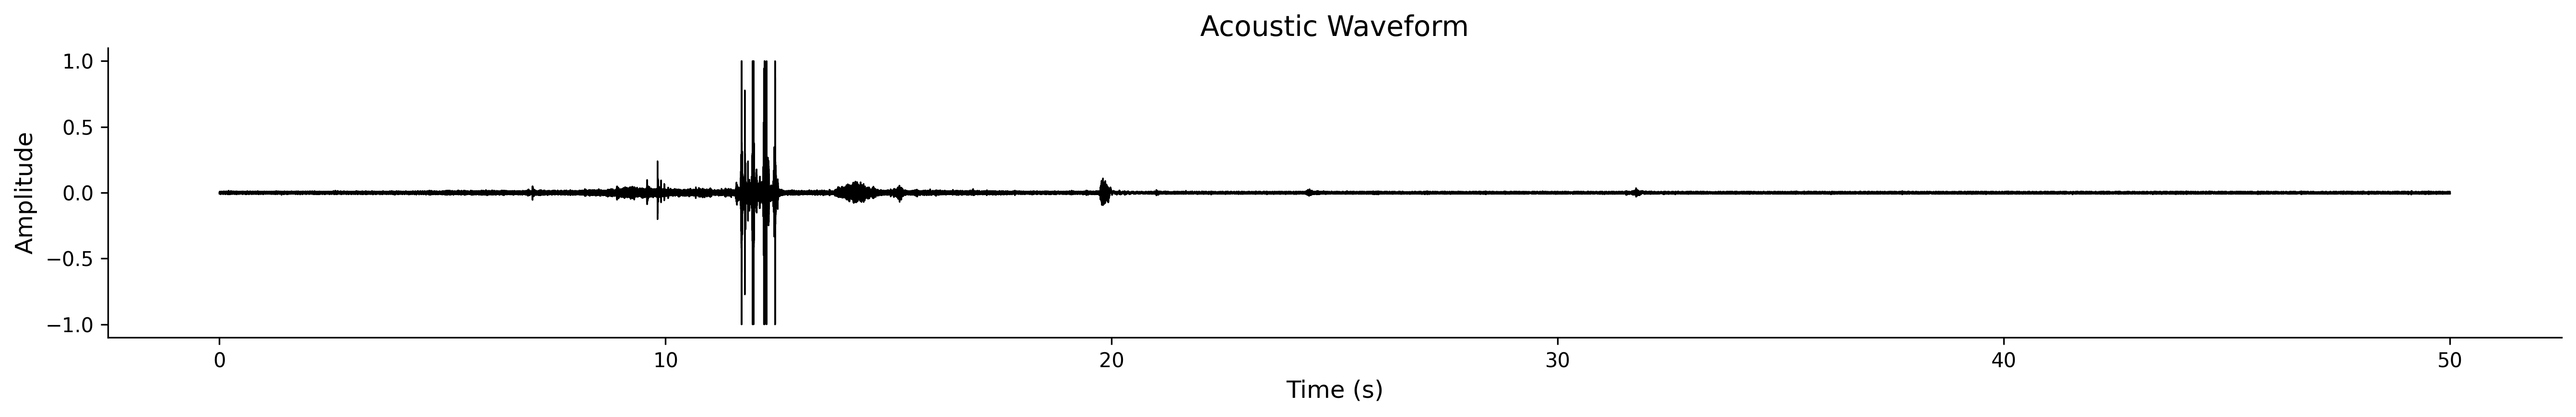

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 0  # seconds
end_time = 50.0  # seconds
timestamps = acoustic_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(acoustic_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(18, 3), dpi=300)

ax.plot(timestamps, data[:], linewidth=0.8, color="black")

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Acoustic Waveform", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=12)
ax.set_xlabel("Time (s)", fontsize=12)

plt.tight_layout()
plt.show()

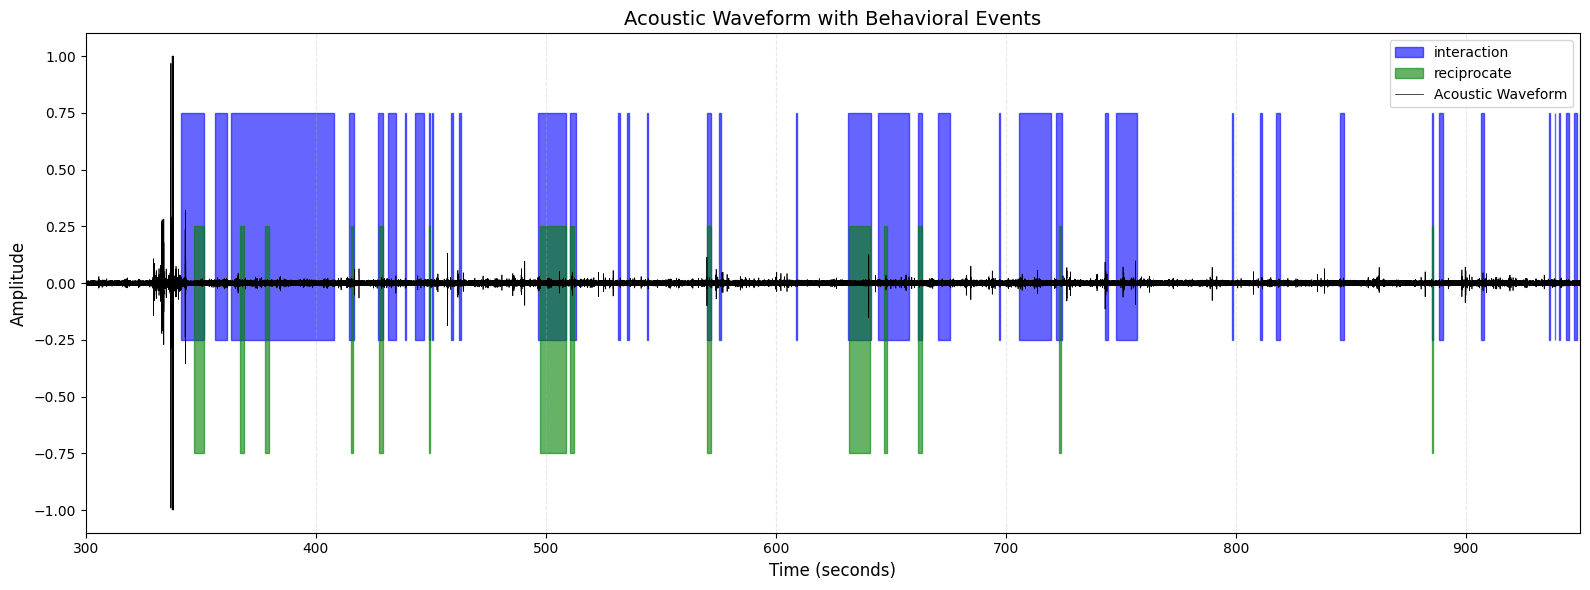

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# Create a single figure
fig, ax = plt.subplots(figsize=(16, 6))

# Get data for the time period
start_time = 300.0 #min([min(row['event_times']) for _, row in behavioral_events.iterrows()])
end_time = max([max(np.array(row['event_times']) + np.array(row['duration'])) 
                for _, row in behavioral_events.iterrows()])
timestamps = acoustic_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1

# Get the data and timestamps properly
data = np.array(acoustic_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Plot acoustic waveform
ax.plot(timestamps, data, linewidth=0.5, color="black", label="Acoustic Waveform")
ax.set_xlim(start_time, end_time)

# Define colors and y-positions for event types (scaled to match waveform amplitude)
colors = {'interaction': 'blue', 'reciprocate': 'green'}
data_range = np.max(data) - np.min(data)
y_base = np.min(data)

# Calculate positions to place event indicators in the same scale as waveform
event_height = 1.0
y_positions = {
    'interaction': -0.25,
    'reciprocate': -0.75
}

# Loop through each row in the behavioral events dataframe
for idx, row in behavioral_events.iterrows():
    label = row['label']
    times = np.array(row['event_times'])
    durations = np.array(row['duration'])
    
    # Plot each event as a rectangle
    for i, (time, duration) in enumerate(zip(times, durations)):
        rect = patches.Rectangle(
            (time, y_positions[label]),
            duration,
            event_height,
            linewidth=1,
            edgecolor=colors[label],
            facecolor=colors[label],
            alpha=0.6,
            label=label if i == 0 else ""
        )
        ax.add_patch(rect)

# Set axis labels
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.set_title('Acoustic Waveform with Behavioral Events', fontsize=14)

# Add a legend without duplicate labels
handles, labels = [], []
for label, color in colors.items():
    patch = patches.Patch(color=color, label=label, alpha=0.6)
    handles.append(patch)
    labels.append(label)
ax.legend(handles + [plt.Line2D([0], [0], color='black', linewidth=0.5)], 
          labels + ['Acoustic Waveform'], 
          loc='upper right')

# Add gridlines for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
